In [1]:
import pandas as pd
import neo4j as neo
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
import seaborn as sns
from graphdatascience import GraphDataScience

/Users/helene.deribaupierre/Library/Caches/pypoetry/virtualenvs/seminaire-2022-4lsZ7u0L-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#source = https://towardsdatascience.com/create-a-graph-database-in-neo4j-using-python-4172d40f89c4
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None

        try:
            self.__driver = neo.GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response
    
    def insert_data(self,query, rows, batch_size = 10000):
        # Function to handle the updating the Neo4j database in batch mode.
        
        total = 0
        batch = 0
        result = None
        
        while batch * batch_size < len(rows):

            res = conn.query(query, 
                            parameters = {'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
            total += res[0]['total']
            batch += 1
            result = {"total":total, 
                    "batches":batch,}
            print(result)
            
        return result



## CONNECTION WITH NEO4J DATABASE

In [2]:
host = "bolt://44.204.150.95:7687"
user = "neo4j"
password= "cakes-resident-pans"

# conn = Neo4jConnection(uri=host, 
#                        user=user,              
#                        pwd=password)

gds = GraphDataScience(host, auth=(user, password))

print(gds.version())

2.2.2


### METADATA OF THE GRAPH

In [337]:
#Nodes metadata

gds.run_cypher("CALL db.schema.nodeTypeProperties()")

,nodeType,nodeLabels,propertyName,propertyTypes,mandatory
0,:`Researcher`,[Researcher],full_name,[String],True
1,:`Researcher`,[Researcher],louvain,[Long],True
2,:`Researcher`,[Researcher],pageRank,[Double],True
3,:`Researcher`,[Researcher],degree_centrality,[Double],True
4,:`Researcher`,[Researcher],researcher_id,[String],True
5,:`Researcher`,[Researcher],last_name,[String],True
6,:`Researcher`,[Researcher],total_number_of_publications,[Long],True
7,:`Researcher`,[Researcher],first_name,"[String, Double]",True
8,:`Field`,[Field],domain,[String],True


In [338]:
#Some metadata
gds.run_cypher("CALL db.schema.relTypeProperties()")

,relType,propertyName,propertyTypes,mandatory
0,:`CO_AUTHORS`,number_of_time,[Long],True
1,:`CO_AUTHORS`,last_year_collaboration,[Long],True
2,:`WORKS_IN`,number_of_publication,[Long],True
3,:`WORKS_IN`,weight_field,[Double],True


### GET THE SCIENTISTS WITH THE MOST PUBLICATIONS IN THE DB

In [427]:
#Get the scientits in unige with the most publications

result_total_publications= gds.run_cypher("MATCH (r:Researcher)-[w:WORKS_IN]-(f:Field) RETURN r.full_name as name, r.researcher_id as researcher_id, r.total_number_of_publications as total, \
collect (f.domain) ORDER BY r.total_number_of_publications DESC LIMIT 80")
result_total_publications.head(10)

,name,researcher_id,total,collect (f.domain)
0,K. Cenzual,ur.014174005714.85,7729,"[Biochemistry and Cell Biology, Organic Chemistry, Other Physical Sciences, Materials Engineering, Physical Chemistry (incl. Structural), Paediatrics and Reproductive Medicine, Information Systems, Geology, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Artificial Intelligence and Image Processing, Geochemistry, Astronomical and Space Sciences, Resources Engineering and Extractive Metallurgy, Condensed Matter Physics, Other Chemical Sciences, Inorganic Chemistry]"
1,X. Wu,ur.01300274247.21,2120,"[Other Physical Sciences, Chemical Engineering, Biomedical Engineering, Statistics, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Artificial Intelligence and Image Processing, Interdisciplinary Engineering, Astronomical and Space Sciences, Mathematical Physics, Optical Physics, Quantum Physics, Resources Engineering and Extractive Metallurgy, Electrical and Electronic Engineering, Condensed Matter Physics, Numerical and Computational Mathematics, Applied Economics]"
2,D. d'Enterria,ur.016312771362.21,1864,"[Other Physical Sciences, Materials Engineering, Statistics, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Artificial Intelligence and Image Processing, Interdisciplinary Engineering, Astronomical and Space Sciences, Mathematical Physics, Quantum Physics, Resources Engineering and Extractive Metallurgy, Condensed Matter Physics, Pure Mathematics]"
3,M. Pierini,ur.014032004363.32,1699,"[Other Physical Sciences, Chemical Engineering, Materials Engineering, Biomedical Engineering, Statistics, Information Systems, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Artificial Intelligence and Image Processing, Interdisciplinary Engineering, Astronomical and Space Sciences, Mathematical Physics, Quantum Physics, Resources Engineering and Extractive Metallurgy, Condensed Matter Physics, Pure Mathematics]"
4,M. Elsing,ur.015440532053.50,1627,"[Other Physical Sciences, Biomedical Engineering, Statistics, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Artificial Intelligence and Image Processing, Interdisciplinary Engineering, Astronomical and Space Sciences, Mathematical Physics, Optical Physics, Quantum Physics, Electrical and Electronic Engineering, Condensed Matter Physics]"
5,L. Malgeri,ur.01201573234.20,1594,"[Other Physical Sciences, Materials Engineering, Statistics, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Artificial Intelligence and Image Processing, Interdisciplinary Engineering, Astronomical and Space Sciences, Mathematical Physics, Optical Physics, Quantum Physics, Resources Engineering and Extractive Metallurgy, Condensed Matter Physics, Pure Mathematics]"
6,T. Wengler,ur.010765257600.38,1377,"[Other Physical Sciences, Chemical Engineering, Materials Engineering, Physical Chemistry (incl. Structural), Biomedical Engineering, Statistics, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Artificial Intelligence and Image Processing, Interdisciplinary Engineering, Astronomical and Space Sciences, Mathematical Physics, Optical Physics, Quantum Physics, Applied Mathematics, Manufacturing Engineering]"
7,M. Lassnig,ur.013744472523.62,1367,"[Other Physical Sciences, Statistics, Information Systems, Computer Software, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Artificial Intelligence and Image Processing, Interdisciplinary Engineering, Astronomical and Space Sciences, Mathematical Physics, Optical Physics, Quantum Physics, Electrical and Electronic Engineering, Condensed Matter Physics, Sociology, Computation Theory and Mathematics]"
8,A. Pfeiffer,ur.011256127372.09,1334,"[Other Physical Sciences, Materials Engineering, Biomedical Engineering, Statistics, Information Systems, Computer Software, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Artificial Intelligence and Image Processing, Interdisciplinary Engineering, Astronomical and Space Sciences, Mathematical P

In [428]:

result_total_publications_map= gds.run_cypher("MATCH (r:Researcher)-[w:WORKS_IN]-(f:Field) RETURN r.full_name, \
r.total_number_of_publications as total, collect({number:w.number_of_publication,field:f.domain}) as field_number ORDER BY total DESC LIMIT 10")
result_total_publications_map.head()

,r.full_name,total,field_number
0,K. Cenzual,7729,"[{'number': 66, 'field': 'Biochemistry and Cell Biology'}, {'number': 1, 'field': 'Organic Chemistry'}, {'number': 1, 'field': 'Other Physical Sciences'}, {'number': 70, 'field': 'Materials Engineering'}, {'number': 950, 'field': 'Physical Chemistry (incl. Structural)'}, {'number': 1, 'field': 'Paediatrics and Reproductive Medicine'}, {'number': 67, 'field': 'Information Systems'}, {'number': 236, 'field': 'Geology'}, {'number': 2495, 'field': 'Atomic, Molecular, Nuclear, Particle and Plasma Physics'}, {'number': 1, 'field': 'Artificial Intelligence and Image Processing'}, {'number': 3, 'field': 'Geochemistry'}, {'number': 393, 'field': 'Astronomical and Space Sciences'}, {'number': 6, 'field': 'Resources Engineering and Extractive Metallurgy'}, {'number': 6, 'field': 'Condensed Matter Physics'}, {'number': 1, 'field': 'Other Chemical Sciences'}, {'number': 3432, 'field': 'Inorganic Chemistry'}]"
1,X. Wu,2120,"[{'number': 480, 'field': 'Other Physical Sciences'}, {'number': 1, 'field': 'Chemical Engineering'}, {'number': 1, 'field': 'Biomedical Engineering'}, {'number': 35, 'field': 'Statistics'}, {'number': 814, 'field': 'Atomic, Molecular, Nuclear, Particle and Plasma Physics'}, {'number': 1, 'field': 'Artificial Intelligence and Image Processing'}, {'number': 5, 'field': 'Interdisciplinary Engineering'}, {'number': 172, 'field': 'Astronomical and Space Sciences'}, {'number': 50, 'field': 'Mathematical Physics'}, {'number': 1, 'field': 'Optical Physics'}, {'number': 252, 'field': 'Quantum Physics'}, {'number': 2, 'field': 'Resources Engineering and Extractive Metallurgy'}, {'number': 4, 'field': 'Electrical and Electronic Engineering'}, {'number': 4, 'field': 'Condensed Matter Physics'}, {'number': 1, 'field': 'Numerical and Computational Mathematics'}, {'number': 1, 'field': 'Applied Economics'}]"
2,D. d'Enterria,1864,"[{'number': 142, 'field': 'Other Physical Sciences'}, {'number': 3, 'field': 'Materials Engineering'}, {'number': 52, 'field': 'Statistics'}, {'number': 934, 'field': 'Atomic, Molecular, Nuclear, Particle and Plasma Physics'}, {'number': 1, 'field': 'Artificial Intelligence and Image Processing'}, {'number': 2, 'field': 'Interdisciplinary Engineering'}, {'number': 125, 'field': 'Astronomical and Space Sciences'}, {'number': 199, 'field': 'Mathematical Physics'}, {'number': 271, 'field': 'Quantum Physics'}, {'number': 1, 'field': 'Resources Engineering and Extractive Metallurgy'}, {'number': 1, 'field': 'Condensed Matter Physics'}, {'number': 5, 'field': 'Pure Mathematics'}]"
3,M. Pierini,1699,"[{'number': 113, 'field': 'Other Physical Sciences'}, {'number': 1, 'field': 'Chemical Engineering'}, {'number': 3, 'field': 'Materials Engineering'}, {'number': 1, 'field': 'Biomedical Engineering'}, {'number': 51, 'field': 'Statistics'}, {'number': 1, 'field': 'Information Systems'}, {'number': 832, 'field': 'Atomic, Molecular, Nuclear, Particle and Plasma Physics'}, {'number': 13, 'field': 'Artificial Intelligence and Image Processing'}, {'number': 2, 'field': 'Interdisciplinary Engineering'}, {'number': 112, 'field': 'Astronomical and Space Sciences'}, {'number': 177, 'field': 'Mathematical Physics'}, {'number': 258, 'field': 'Quantum Physics'}, {'number': 1, 'field': 'Resources Engineering and Extractive Metallurgy'}, {'number': 4, 'field': 'Condensed Matter Physics'}, {'number': 5, 'field': 'Pure Mathematics'}]"
4,M. Elsing,1627,"[{'number': 506, 'field': 'Other Physical Sciences'}, {'number': 3, 'field': 'Biomedical Engineering'}, {'number': 22, 'field': 'Statistics'}, {'number': 650, 'field': 'Atomic, Molecular, Nuclear, Particle and Plasma Physics'}, {'number': 1, 'field': 'Artificial Intelligence and Image Processing'}, {'number': 1, 'field': 'Interdisciplinary Engineering'}, {'number': 102, 'field': 'Astronomical and Space Sciences'}, {'number': 115, 'field': 'Mathematical Physics'}, {'number': 3, 'field': 'Optical Physics'}, {'number': 177, 'field': 'Quantum

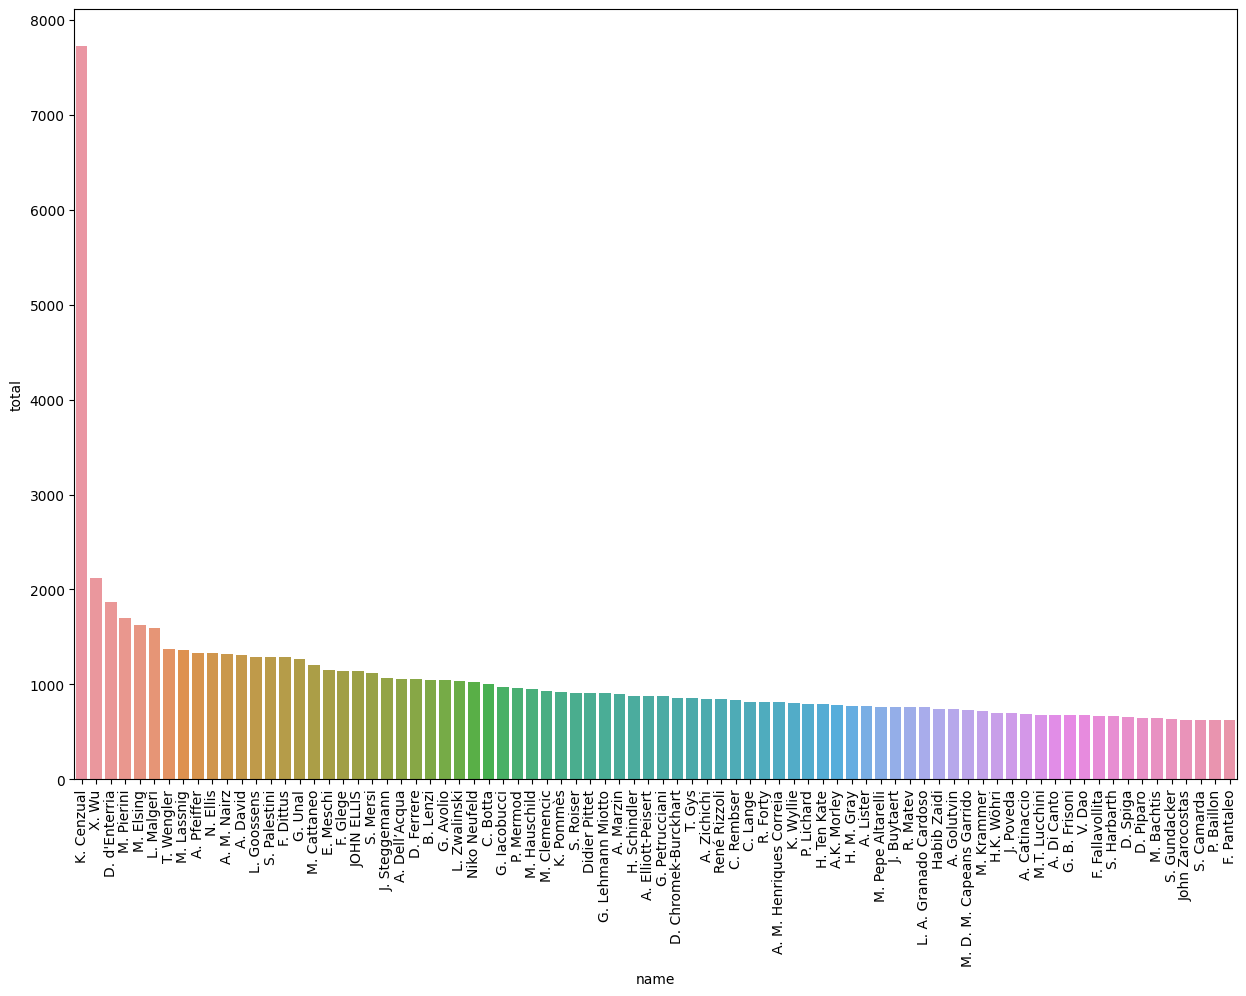

In [419]:
g = sns.barplot(x=result_total_publications["name"], y=result_total_publications["total"])
g = g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [341]:
#Get the field which has the most publications
result_domain_count = gds.run_cypher("MATCH (r:Researcher)-[w:WORKS_IN]-(f:Field) RETURN f.domain as domain, count(*) as number_time ORDER BY  number_time DESC LIMIT 20")
result_domain_count.head()

,domain,number_time
0,Clinical Sciences,15891
1,Public Health and Health Services,13093
2,"Atomic, Molecular, Nuclear, Particle and Plasma Physics",11692
3,Other Physical Sciences,11401
4,Biochemistry and Cell Biology,6294


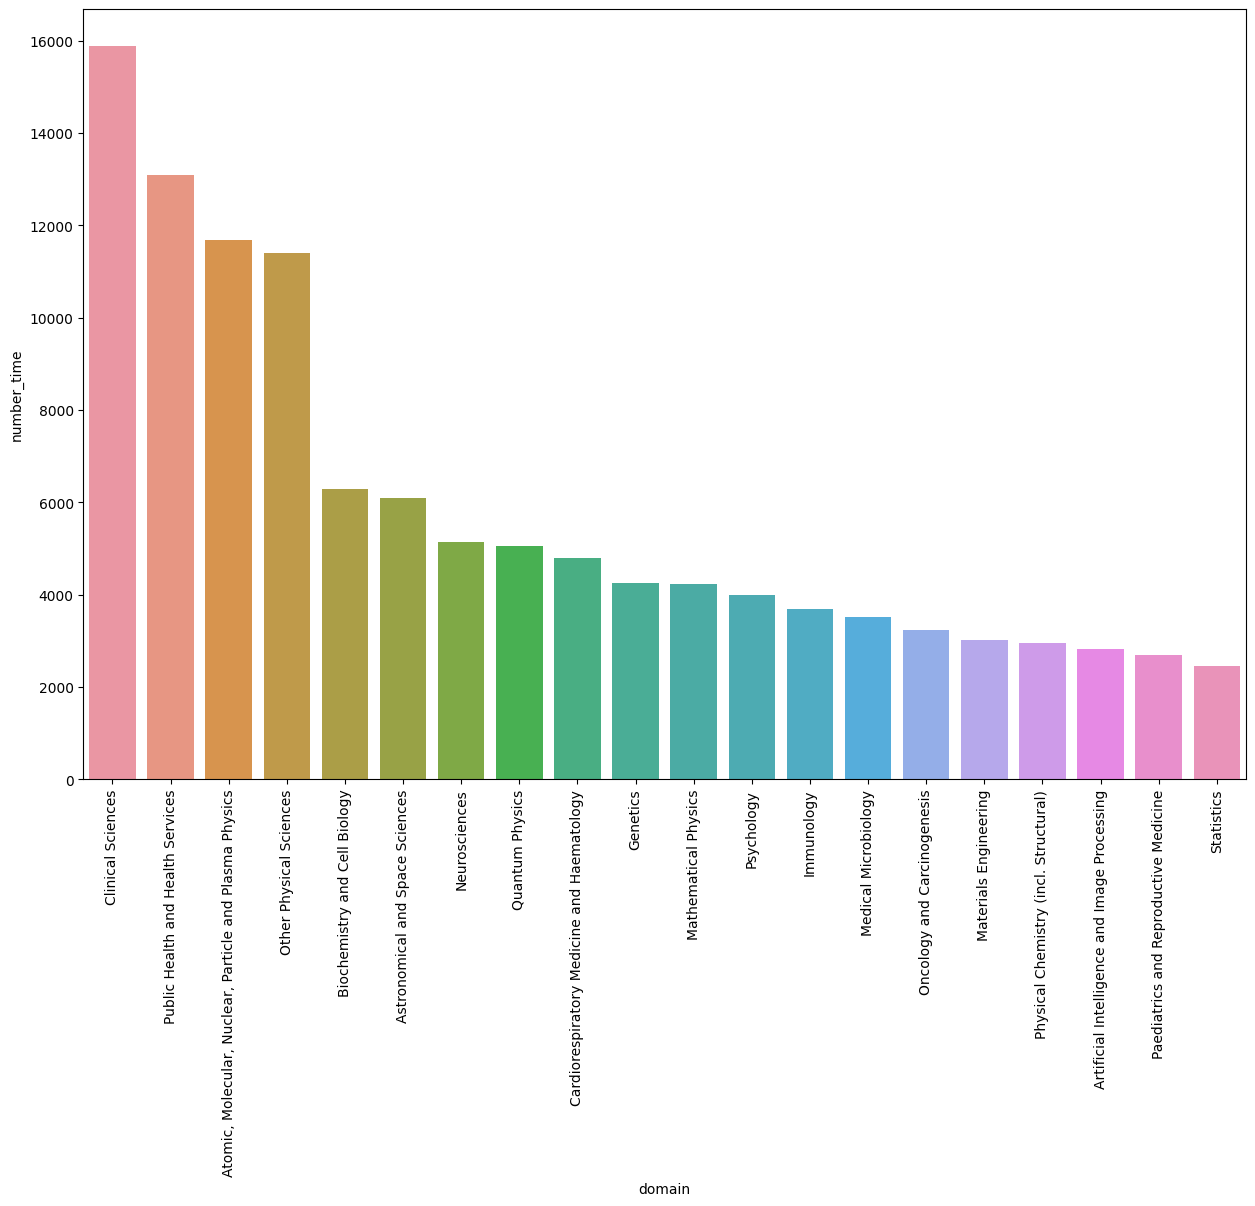

In [342]:
g = sns.barplot(x=result_domain_count["domain"], y=result_domain_count["number_time"])
g =g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [343]:
#Get the researcher that works in several research fields.
result_field = gds.run_cypher("MATCH (r:Researcher)-[w:WORKS_IN]-(f:Field) RETURN r.full_name as name, r.researcher_id as researcher_id, count(*) as fields ORDER BY  fields DESC LIMIT 30")
result_field.head()

,name,researcher_id,fields
0,BASTIEN CHOPARD,ur.016275067565.80,46
1,S Rudaz,ur.0605706427.85,37
2,A. Zichichi,ur.012521521573.71,36
3,Jean-Charles Sanchez,ur.01326260071.22,32
4,Bernice S. Elger,ur.01306617426.43,31


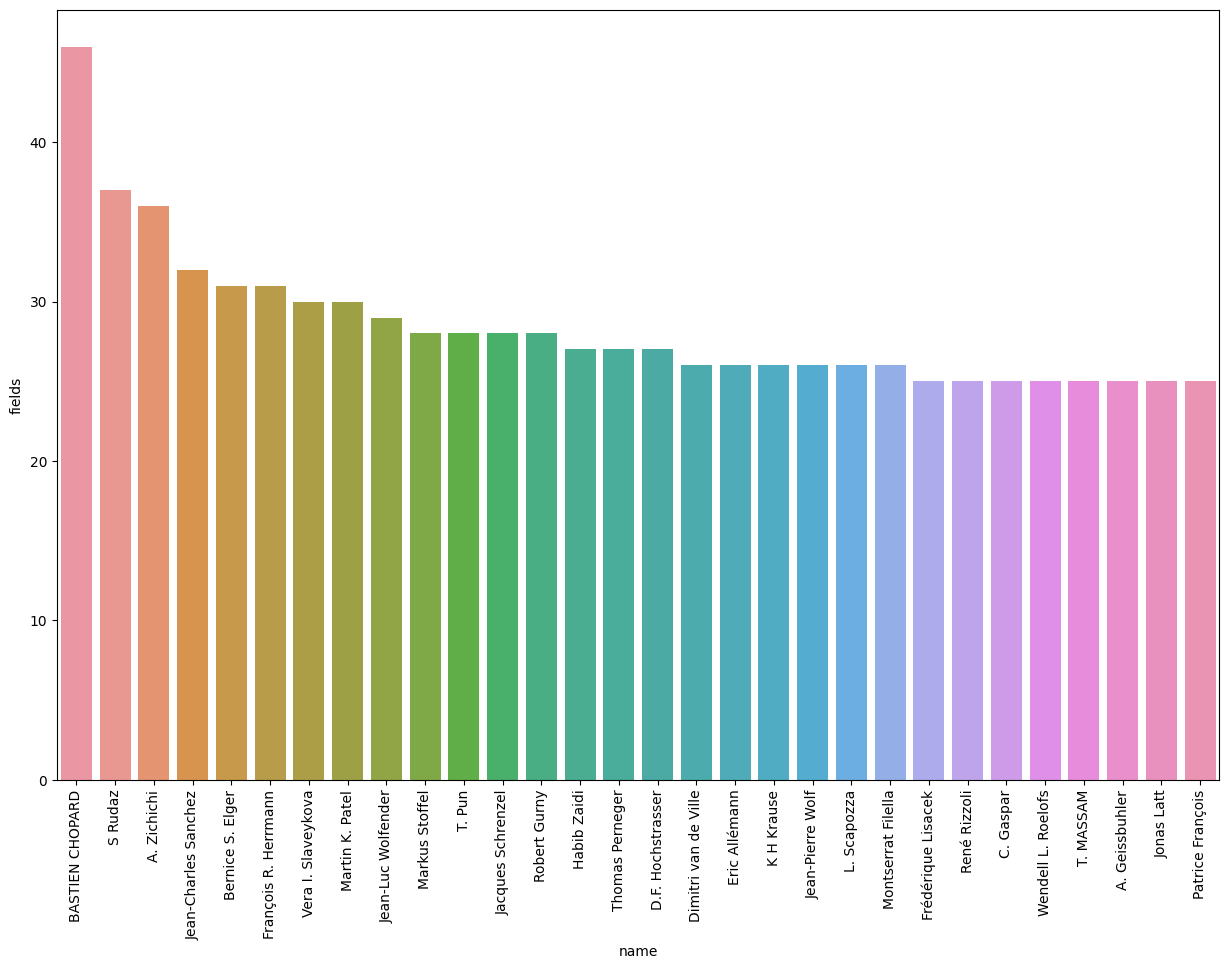

In [344]:
g = sns.barplot(x=result_field["name"], y=result_field["fields"])
g = g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [345]:
choppard = gds.run_cypher("MATCH (r:Researcher{researcher_id:'ur.016275067565.80'})-[w:WORKS_IN]-(f:Field) RETURN r.full_name as full_name, count(*) as total_fields, collect(f.domain) as domain")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
print(choppard.domain)

0    [Maritime Engineering, Civil Engineering, Distributed Computing, Statistics, Applied Economics, Geomatic Engineering, Other Chemical Sciences, Theoretical and Computational Chemistry, Inorganic Chemistry, Cognitive Sciences, Genetics, Physiology, Banking, Finance and Investment, Physical Chemistry (incl. Structural), Interdisciplinary Engineering, Quantum Physics, Geology, Chemical Engineering, Environmental Engineering, Optical Physics, Information Systems, Materials Engineering, Zoology, Clinical Sciences, Communications Technologies, Physical Geography and Environmental Geoscience, Medical Physiology, Organic Chemistry, Numerical and Computational Mathematics, Data Format, Econometrics, Cardiorespiratory Medicine and Haematology, Biomedical Engineering, Artificial Intelligence and Image Processing, Computation Theory and Mathematics, Applied Mathematics, Mechanical Engineering, Biochemistry and Cell Biology, Geophysics, Computer Software, Pure Mathematics, Human Movement and Sp

In [346]:
field_computer_science = ["Information Systems","Computer Software","Data Format",
"Artificial Intelligence and Image Processing","Computation Theory and Mathematics","Other Information and Computing Sciences",
"Library and Information Studies","Computer Hardware"]
field_computer_science

['Information Systems',
 'Computer Software',
 'Data Format',
 'Artificial Intelligence and Image Processing',
 'Computation Theory and Mathematics',
 'Other Information and Computing Sciences',
 'Library and Information Studies',
 'Computer Hardware']

In [347]:
#Get the researcher with the most publications in Computer Science 

query_number_publications_in_computer_science_person =f"MATCH(r:Researcher)-[w:WORKS_IN]-(f:Field) WHERE f.domain IN {field_computer_science} \
and w.weight_field > 1 return distinct r.full_name as name,r.researcher_id as researcher_id, r.total_number_of_publications as total_publication ORDER by r.total_number_of_publications DESC"
result_number_publication_person_computer_science = gds.run_cypher(query_number_publications_in_computer_science_person)
result_number_publication_person_computer_science.head(20)

,name,researcher_id,total_publication
0,Habib Zaidi,ur.01300453230.34,741
1,Nadia Magnenat-Thalmann,ur.0704711431.38,533
2,Dimitri van de Ville,ur.01041204034.82,418
3,BASTIEN CHOPARD,ur.016275067565.80,339
4,Amos Bairoch,ur.01076543625.00,233
5,Osman Ratib,ur.0617321230.19,230
6,Henning Müller,ur.07552063233.67,218
7,T. Pun,ur.01212142027.87,212
8,Christian Lovis,ur.01133331655.52,196
9,Frédérique Lisacek,ur.0674012177.79,195


In [348]:
query_informatique_fields = (f"MATCH(n:Researcher)-[w:WORKS_IN]-(f:Field) WHERE f.domain \
IN {field_computer_science}  RETURN DISTINCT n.full_name, n.researcher_id as researcher, f.domain, w.weight_field ORDER by w.weight_field DESC")
result_informatique_field = gds.run_cypher(query_informatique_fields)
result_informatique_field.head(10)

,n.full_name,researcher,f.domain,w.weight_field
0,Henning Müller,ur.07552063233.67,Artificial Intelligence and Image Processing,11.605505
1,Nadia Magnenat-Thalmann,ur.0704711431.38,Artificial Intelligence and Image Processing,11.227017
2,T. Pun,ur.01212142027.87,Artificial Intelligence and Image Processing,10.566038
3,Nadia Magnenat Thalmann,ur.013317560667.45,Artificial Intelligence and Image Processing,7.442748
4,Stéphane Marchand-Maillet,ur.016472056171.12,Artificial Intelligence and Image Processing,7.264368
5,Michel Leonard,ur.01066422007.20,Information Systems,7.183673
6,Habib Zaidi,ur.01300453230.34,Artificial Intelligence and Image Processing,6.558704
7,P. Volino,ur.07527316741.46,Artificial Intelligence and Image Processing,6.176471
8,M. Hilario,ur.010323216605.25,Artificial Intelligence and Image Processing,6.139535
9,Patrick Ruch,ur.016176475704.89,Artificial Intelligence and Image Processing,6.055046


In [349]:
#Get the researcher that works in several research fields.
result_field = gds.run_cypher(f"MATCH (r:Researcher)-[w:WORKS_IN]-(f:Field) WHERE f.domain \
IN {field_computer_science} and w.weight_field > 5 with r,f MATCH (r)-[ww:WORKS_IN]-(ff:Field)  \
RETURN r.full_name,r.researcher_id as researcher_id, r.total_number_of_publications as total_publication,collect( DISTINCT f.domain) as domain_computer, \
count(ff.domain) as count_all_domain, collect(ff.domain) as all_domain   \
ORDER BY total_publication DESC ")
result_field.head(20)

,r.full_name,researcher_id,total_publication,domain_computer,count_all_domain,all_domain
0,Habib Zaidi,ur.01300453230.34,741,[Artificial Intelligence and Image Processing],27,"[Physiology, Astronomical and Space Sciences, Artificial Intelligence and Image Processing, Pharmacology and Pharmaceutical Sciences, Optical Physics, Biochemistry and Cell Biology, Materials Engineering, Theoretical and Computational Chemistry, Statistics, Other Physical Sciences, Information Systems, Paediatrics and Reproductive Medicine, Public Health and Health Services, Atomic, Molecular, Nuclear, Particle and Plasma Physics, Electrical and Electronic Engineering, Oncology and Carcinogenesis, Numerical and Computational Mathematics, Medical Physiology, Clinical Sciences, Cardiorespiratory Medicine and Haematology, Human Movement and Sports Science, Psychology, Biomedical Engineering, Computation Theory and Mathematics, Neurosciences, Cognitive Sciences, Computer Software]"
1,Nadia Magnenat-Thalmann,ur.0704711431.38,533,[Artificial Intelligence and Image Processing],22,"[Manufacturing Engineering, Artificial Intelligence and Image Processing, Information Systems, Computer Software, Materials Engineering, Statistics, Electrical and Electronic Engineering, Architecture, Curatorial and Related Studies, Psychology, Numerical and Computational Mathematics, Biomedical Engineering, Computation Theory and Mathematics, Design Practice and Management, Specialist Studies In Education, Neurosciences, Human Movement and Sports Science, Cognitive Sciences, Mechanical Engineering, Clinical Sciences, Curriculum and Pedagogy, Cultural Studies]"
2,Henning Müller,ur.07552063233.67,218,[Artificial Intelligence and Image Processing],23,"[Cognitive Sciences, Computer Software, Communications Technologies, Psychology, Neurosciences, Information Systems, Biochemistry and Cell Biology, Cardiorespiratory Medicine and Haematology, Oncology and Carcinogenesis, Human Movement and Sports Science, Public Health and Health Services, Biomedical Engineering, Analytical Chemistry, Data Format, Electrical and Electronic Engineering, Linguistics, Medical Biotechnology, Distributed Computing, Clinical Sciences, Statistics, Computation Theory and Mathematics, Other Biological Sciences, Artificial Intelligence and Image Processing]"
3,T. Pun,ur.01212142027.87,212,[Artificial Intelligence and Image Processing],28,"[Pure Mathematics, Civil Engineering, Artificial Intelligence and Image Processing, Cultural Studies, Information Systems, Computer Software, Biomedical Engineering, Psychology, Communications Technologies, Computation Theory and Mathematics, Cardiorespiratory Medicine and Haematology, Environmental Science and Management, Statistics, Other Physical Sciences, Medical Biotechnology, Applied Economics, Electrical and Electronic Engineering, Design Practice and Management, Cognitive Sciences, Clinical Sciences, Other Biological Sciences, Film, Television and Digital Media, Dentistry, Data Format, Neurosciences, Distributed Computing, Optical Physics, Medical Biochemistry and Metabolomics]"
4,Stéphane Marchand-Maillet,ur.016472056171.12,174,"[Information Systems, Artificial Intelligence and Image Processing]",32,"[Computer Software, Psychology, Geomatic Engineering, Ecology, Architecture, Data Format, Pure Mathematics, Public Health and Health Services, Computation Theory and Mathematics, Statistics, Information Systems, Econometrics, Environmental Science and Management, Artificial Intelligence and Image Processing, Electrical and Electronic Engineering, Archaeology, Computer Software, Psychology, Geomatic Engineering, Ecology, Architecture, Data Format, Pure Mathematics, Public Health and Health Services, Computation Theory and Mathematics, Statistics, Information Systems, Econometrics, Environmental Science and Management, Artificial Intelligence and Image Processing, Electrical and Electronic Engineering, Archaeology]"
5,Nadia Magnenat Thalmann,ur.013317560667.45,131,[Artificial I

In [350]:
graph_name = "co_authors_graph"

In [351]:
result = gds.run_cypher("""CALL gds.graph.drop($params,false) YIELD graphName""",params={"params":graph_name}) # drop the graph and do not raise the error if the graph is not found.
result = gds.run_cypher("""CALL gds.graph.project($params, 'Researcher', 'CO_AUTHORS')""",params={"params":graph_name})
result

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Researcher': {'label': 'Researcher', 'properties': {}}}","{'CO_AUTHORS': {'orientation': 'NATURAL', 'aggregation': 'DEFAULT', 'type': 'CO_AUTHORS', 'properties': {}}}",co_authors_graph,64849,697374,419


### Difference between centrality and betweeeness measures

Degree centrality measures the number of incoming or outgoing (or both) relationships from a node, depending on the orientation of a relationship projection.

Betweenness centrality is a way of detecting the amount of influence a node has over the flow of information in a graph. It is often used to find nodes that serve as a bridge from one part of a graph to another.

In [352]:
#Stream the result for the degree centrality 

result = gds.run_cypher(
f" CALL gds.degree.stream($params) YIELD nodeId, score RETURN gds.util.asNode(nodeId).full_name AS name, score ORDER BY score DESC, name ASC", params={"params":graph_name}
)
result.head()

,name,score
0,M. Elsing,1811.0
1,N. Ellis,1674.0
2,T. Wengler,1626.0
3,F. Dittus,1623.0
4,A. M. Nairz,1574.0


In [353]:
#write the data in the graph
result = gds.run_cypher(f"CALL gds.degree.write($params_graph, {{writeProperty: 'degree_centrality'}})",params={"params_graph":graph_name})
result


,nodePropertiesWritten,centralityDistribution,writeMillis,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,64849,"{'p99': 144.00096893310547, 'min': 0.0, 'max': 1811.0078048706055, 'mean': 10.75384267551621, 'p90': 18.00011444091797, 'p50': 1.0, 'p999': 993.0038986206055, 'p95': 40.00023651123047, 'p75': 6.000022888183594}",149,107,0,0,"{'jobId': '35706cbd-27b4-4294-baab-461cb615da13', 'orientation': 'NATURAL', 'writeConcurrency': 4, 'writeProperty': 'degree_centrality', 'nodeLabels': ['*'], 'sudo': False, 'relationshipTypes': ['*'], 'concurrency': 4}"


In [354]:
# #difficult to run on AURO DS
# result_betweeness = gds.run_cypher(
# f" CALL gds.betweenness.write($params_graph, {{writeProperty: 'betweeness'}})",params={"params_graph":graph_name})
# result_betweeness


### PageRank
The PageRank algorithm measures the importance of each node within the graph, based on the number 
incoming relationships and the importance of the corresponding source nodes. 
The underlying assumption roughly speaking is that a page is only as important as the pages that link to it.


In [355]:
result_page_rank = gds.run_cypher(
f" CALL gds.pageRank.stream($params)\
YIELD nodeId, score \
RETURN gds.util.asNode(nodeId).full_name AS name, score \
ORDER BY score DESC, name ASC" , params={"params":graph_name}
)
result_page_rank.head(10)

,name,score
0,H. J. Stelzer,31.803249
1,K. Schmieden,17.394491
2,G. Anders,16.506594
3,O. Arnaez,12.033890
4,A. Ruiz-Martinez,11.943163
5,P. O. Deviveiros,10.866444
6,P. S. Wells,9.867472
7,M. Mulders,9.106230
8,G. Sarpis,8.756139
9,A. Pfeiffer,8.673148


In [356]:
result_page_rank = gds.run_cypher(
f" CALL gds.pageRank.write($params_graph, {{writeProperty: 'pageRank'}})",params={"params_graph":graph_name})
result_page_rank

,writeMillis,nodePropertiesWritten,ranIterations,didConverge,centralityDistribution,postProcessingMillis,preProcessingMillis,computeMillis,configuration
0,420,64849,20,False,"{'p99': 1.4409093856811523, 'min': 0.14999961853027344, 'max': 31.803343772888184, 'mean': 0.3199520104613311, 'p90': 0.5608129501342773, 'p50': 0.22834205627441406, 'p999': 3.6714773178100586, 'p95': 0.7636899948120117, 'p75': 0.35419178009033203}",112,0,565,"{'jobId': '8d227297-2b60-463e-911d-7f69bae75fcc', 'maxIterations': 20, 'writeConcurrency': 4, 'sourceNodes': [], 'writeProperty': 'pageRank', 'scaler': 'NONE', 'nodeLabels': ['*'], 'sudo': False, 'dampingFactor': 0.85, 'relationshipTypes': ['*'], 'tolerance': 1e-07, 'concurrency': 4}"


In [357]:
betweeness_df = gds.run_cypher(f"MATCH (n:Researcher)-[w:WORKS_IN]-(f:Field) WHERE f.domain IN {field_computer_science} and w.weight_field>3 return DISTINCT n.full_name, n.pageRank as pageRank ORDER by pageRank DESC LIMIT 20")
centrality_df = gds.run_cypher(f"MATCH (n:Researcher)-[w:WORKS_IN]-(f:Field) WHERE f.domain IN {field_computer_science} and w.weight_field>3 return DISTINCT n.full_name, n.degree_centrality as centrality_score ORDER by centrality_score  DESC LIMIT 20")

In [358]:
merged = betweeness_df.merge(centrality_df,on="n.full_name",how="outer")
merged

,n.full_name,pageRank,centrality_score
0,Emilie Pasche,0.818950,NaN
1,Yazdan Salimi,0.425601,NaN
2,L. Moccozet,0.423966,NaN
3,Sandra Orchard,0.350991,99.0
4,Julien Mariethoz,0.328240,NaN
5,Sviatoslav Voloshynovskiy,0.325559,NaN
6,S. Gil,0.318552,NaN
7,S. Voloshynovskiy,0.312398,NaN
8,J.M. Le Goff,0.287857,NaN
9,A. Geissbuhler,0.287166,127.0


In [359]:
merged.iloc[:,1:]= merged.iloc[:,1:].transform(lambda x: x / abs(x).max())
merged.fillna(0,inplace=True)
merged.set_index("n.full_name",inplace=True)
merged

,pageRank,centrality_score
n.full_name,,
Emilie Pasche,1.000000,0.000000
Yazdan Salimi,0.519691,0.000000
L. Moccozet,0.517694,0.000000
Sandra Orchard,0.428586,0.572254
Julien Mariethoz,0.400806,0.000000
Sviatoslav Voloshynovskiy,0.397532,0.000000
S. Gil,0.388975,0.000000
S. Voloshynovskiy,0.381462,0.000000
J.M. Le Goff,0.351495,0.000000


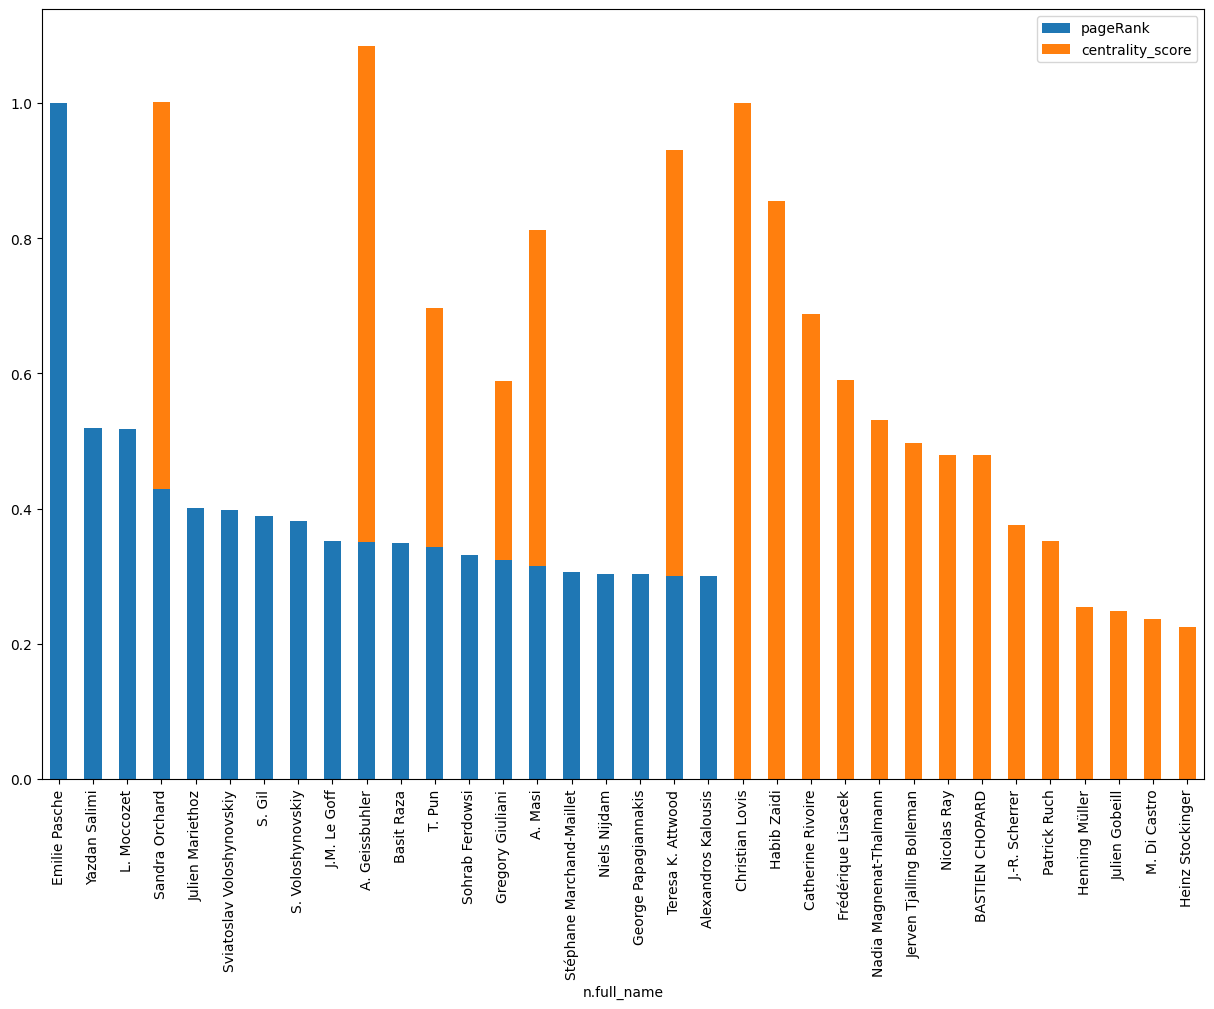

In [360]:
p = merged.plot.bar(stacked=True)
p = p.set_xticklabels(p.get_xticklabels(), rotation=90)


In [400]:
#Paper written by Jean-Henry Morin and Gilles Falquet with the inference rule

result_inference = gds.run_cypher(f"UNWIND $full_name as full_name\
        MATCH (res_1:Researcher{{full_name:full_name}}) CALL apoc.neighbors.athop(res_1, 'CO_AUTHORS', 2) \
        yield node as res_2  \
        MATCH (res_1)-[w_1:WORKS_IN]->(f:Field) \
        MATCH (res_2)-[w_2:WORKS_IN]->(f:Field) \
        WHERE (w_2.weight_field-$difference_weight_field)<= w_1.weight_field <=(w_2.weight_field+$difference_weight_field) \
        AND w_1.weight_field > $minimum_weight_field \
        and res_1 <> res_2 \
        RETURN DISTINCT res_1.full_name as full_name_author, res_2.full_name as reviewer_full_name,res_2.researcher_id as reviewer_id, round((w_2.weight_field+w_1.weight_field)/2,3) as score \
        ",params={"full_name":["Jean-Henry Morin","Gilles Falquet"],"difference_weight_field":0.8,"minimum_weight_field":0.8})
result_inference.head(100)



,full_name_author,reviewer_full_name,reviewer_id,score
0,Jean-Henry Morin,Michel Leonard,ur.01066422007.20,0.815
1,Jean-Henry Morin,Katarzyna Wac,ur.010234164203.55,3.761
2,Jean-Henry Morin,Gilles Falquet,ur.016167755437.37,4.318
3,Jean-Henry Morin,Wanda Opprecht,ur.010515705775.36,0.879
4,Jean-Henry Morin,Manuel Oriol,ur.07707347217.57,1.516
5,Gilles Falquet,J.-R. Scherrer,ur.011513471764.56,2.925
6,Gilles Falquet,Osman Ratib,ur.0617321230.19,2.459
7,Gilles Falquet,Jolita Ralyté,ur.012265620367.64,4.246
8,Gilles Falquet,Christian Lovis,ur.01133331655.52,4.553
9,Gilles Falquet,Christian Lovis,ur.01133331655.52,2.864


In [362]:
graph_result = gds.run_cypher("""
CALL gds.graph.project('co_authors_graph_weight', 'Researcher', {CO_AUTHORS:{properties:"number_of_time"}})
""")

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.project`: Caused by: java.lang.IllegalArgumentException: A graph with name 'co_authors_graph_weight' already exists.}

In [363]:
#LOUVAIN


result_stream_louvain = gds.run_cypher("""
CALL gds.louvain.stream('co_authors_graph_weight',{relationshipWeightProperty:"number_of_time"})
YIELD nodeId, communityId, intermediateCommunityIds
RETURN gds.util.asNode(nodeId).full_name AS full_name, communityId, intermediateCommunityIds
ORDER BY full_name ASC""")
result_stream_louvain.head()


,full_name,communityId,intermediateCommunityIds
0,4 Gualtiero Palareti3,54546,None
1,A A Pol,7140,None
2,A ANDRIANAKI,62377,None
3,A Abad Rodriguez,7140,None
4,A Abramov,7140,None


In [364]:
result_stream_louvain = gds.run_cypher("""
CALL gds.louvain.write('co_authors_graph_weight',{relationshipWeightProperty:"number_of_time", writeProperty:"louvain"})
YIELD communityCount, modularity, modularities""")
result_stream_louvain.head()


,communityCount,modularity,modularities
0,16467,0.663753,"[0.43926460491681146, 0.5881966306111379, 0.6507693183973605, 0.660321598996685, 0.6615302741216783, 0.6623511363333423, 0.6629877859156746, 0.6633508922116249, 0.6635841729259425, 0.6637534891929828]"


In [365]:
louvain_df = gds.run_cypher(f"MATCH (n:Researcher)-[w:WORKS_IN]-(f:Field) WHERE f.domain IN {field_computer_science} and w.weight_field>3 return DISTINCT n.full_name, n.louvain as pageRank ORDER by pageRank DESC LIMIT 20")
louvain_df

,n.full_name,pageRank
0,M. Di Castro,61013
1,Vladimir Loncar,61013
2,A. Masi,61013
3,J.M. Le Goff,61013
4,J.-R. Scherrer,55186
5,Julien Mariethoz,55186
6,Christian Lovis,55186
7,Sviatoslav Voloshynovskiy,55186
8,Jérôme Schmid,55186
9,Nadia Magnenat-Thalmann,55186


In [379]:
louvain_gilles_jean_henry = gds.run_cypher(f"MATCH (n:Researcher)-[w:WORKS_IN]-(f:Field) \
WHERE n.full_name='Jean-Henry Morin' return DISTINCT n.full_name, n.louvain as louvain \
UNION \
MATCH (n:Researcher)-[w:WORKS_IN]-(f:Field) \
WHERE n.full_name='Gilles Falquet' return DISTINCT n.full_name, n.louvain as louvain")
louvain_gilles_jean_henry

,n.full_name,louvain
0,Jean-Henry Morin,4125
1,Gilles Falquet,26571


In [409]:
#return the researcher that are in the same community than Gilles and Jean-Henry
louvain_other = gds.run_cypher(f"MATCH (n:Researcher)-[w:WORKS_IN]-(f:Field) WHERE n.louvain IN {louvain_gilles_jean_henry.louvain.tolist()} \
RETURN DISTINCT n.full_name as full_name, n.researcher_id as researcher_id, n.louvain")
louvain_other.head()

,full_name,researcher_id,n.louvain
0,Paul R. Hunter,ur.01255356036.46,26571
1,Michel Leonard,ur.01066422007.20,26571
2,Simona Zipursky,ur.01145320545.18,26571
3,Alejandro Ramirez Gonzalez,ur.013065015327.56,26571
4,Emily Wootton,ur.010031000127.92,26571


In [414]:
result_inference.merge(louvain_other, how="left", left_on="reviewer_id",right_on="researcher_id").drop(columns=["researcher_id","full_name"]).head(20).sort_values(by="n.louvain")

,full_name_author,reviewer_full_name,reviewer_id,score,n.louvain
1,Jean-Henry Morin,Katarzyna Wac,ur.010234164203.55,3.761,4125.0
4,Jean-Henry Morin,Manuel Oriol,ur.07707347217.57,1.516,4125.0
17,Gilles Falquet,Jean-Henry Morin,ur.0631021307.20,4.318,4125.0
0,Jean-Henry Morin,Michel Leonard,ur.01066422007.20,0.815,26571.0
2,Jean-Henry Morin,Gilles Falquet,ur.016167755437.37,4.318,26571.0
3,Jean-Henry Morin,Wanda Opprecht,ur.010515705775.36,0.879,26571.0
7,Gilles Falquet,Jolita Ralyté,ur.012265620367.64,4.246,26571.0
16,Gilles Falquet,Eric Wehrli,ur.01242625577.43,2.385,26571.0
5,Gilles Falquet,J.-R. Scherrer,ur.011513471764.56,2.925,NaN
6,Gilles Falquet,Osman Ratib,ur.0617321230.19,2.459,NaN


In [ ]:
#LOUVAIN 2

_column

In [ ]:
# graph_result = gds.run_cypher("""
# CALL gds.graph.project('co_authors_graph_weight', 'Researcher', {CO_AUTHORS:{properties:"number_of_time"}})
# """)
# graph_result
# f, axs = plt.subplots(1,2,figsize=(16,5))

# g = sns.barplot(ax=axs[0], x=merged["n.full_name"], y=merged["betweeness_score"])
# b = sns.barplot(ax=axs[1],x=merged["n.full_name"], y=merged["centrality_score"])

# g.set_xticklabels(g.get_xticklabels(), rotation=90)
# b.set_xticklabels(g.get_xticklabels(), rotation=90)

# plt.show()

